<a href="https://colab.research.google.com/github/gankidisaicharan/Morphed-Face-Detection/blob/main/MorphedImageDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pathlib
import numpy as np
import random
import matplotlib.pyplot as plt
import os
import pandas as pd
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')


In [ ]:
from os import listdir
from keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import imutils
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle #shuffling the data improves the model

In [ ]:
import cv2
import os
input_dir = '/content/drive/MyDrive/PROJECTS/morphed face detection/images for morphing'
output_dir = '/content/drive/MyDrive/PROJECTS/morphed face detection/dataset/morphed images'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
for filename in os.listdir(input_dir):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        img = cv2.imread(os.path.join(input_dir, filename))
        ksize = (15, 15)
        sigma = 0
        morph_type = cv2.MORPH_RECT
        img_blur = cv2.GaussianBlur(img, ksize, sigma)
        img_morph = cv2.addWeighted(img, 0.5, img_blur, 0.5, 0)
        cv2.imwrite(os.path.join(output_dir, filename), img_morph)

In [ ]:
import pathlib
import numpy as np
file_path = '/content/drive/MyDrive/PROJECTS/morphed face detection/dataset'
data_dir = pathlib.Path(file_path)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['images' 'morphed images']


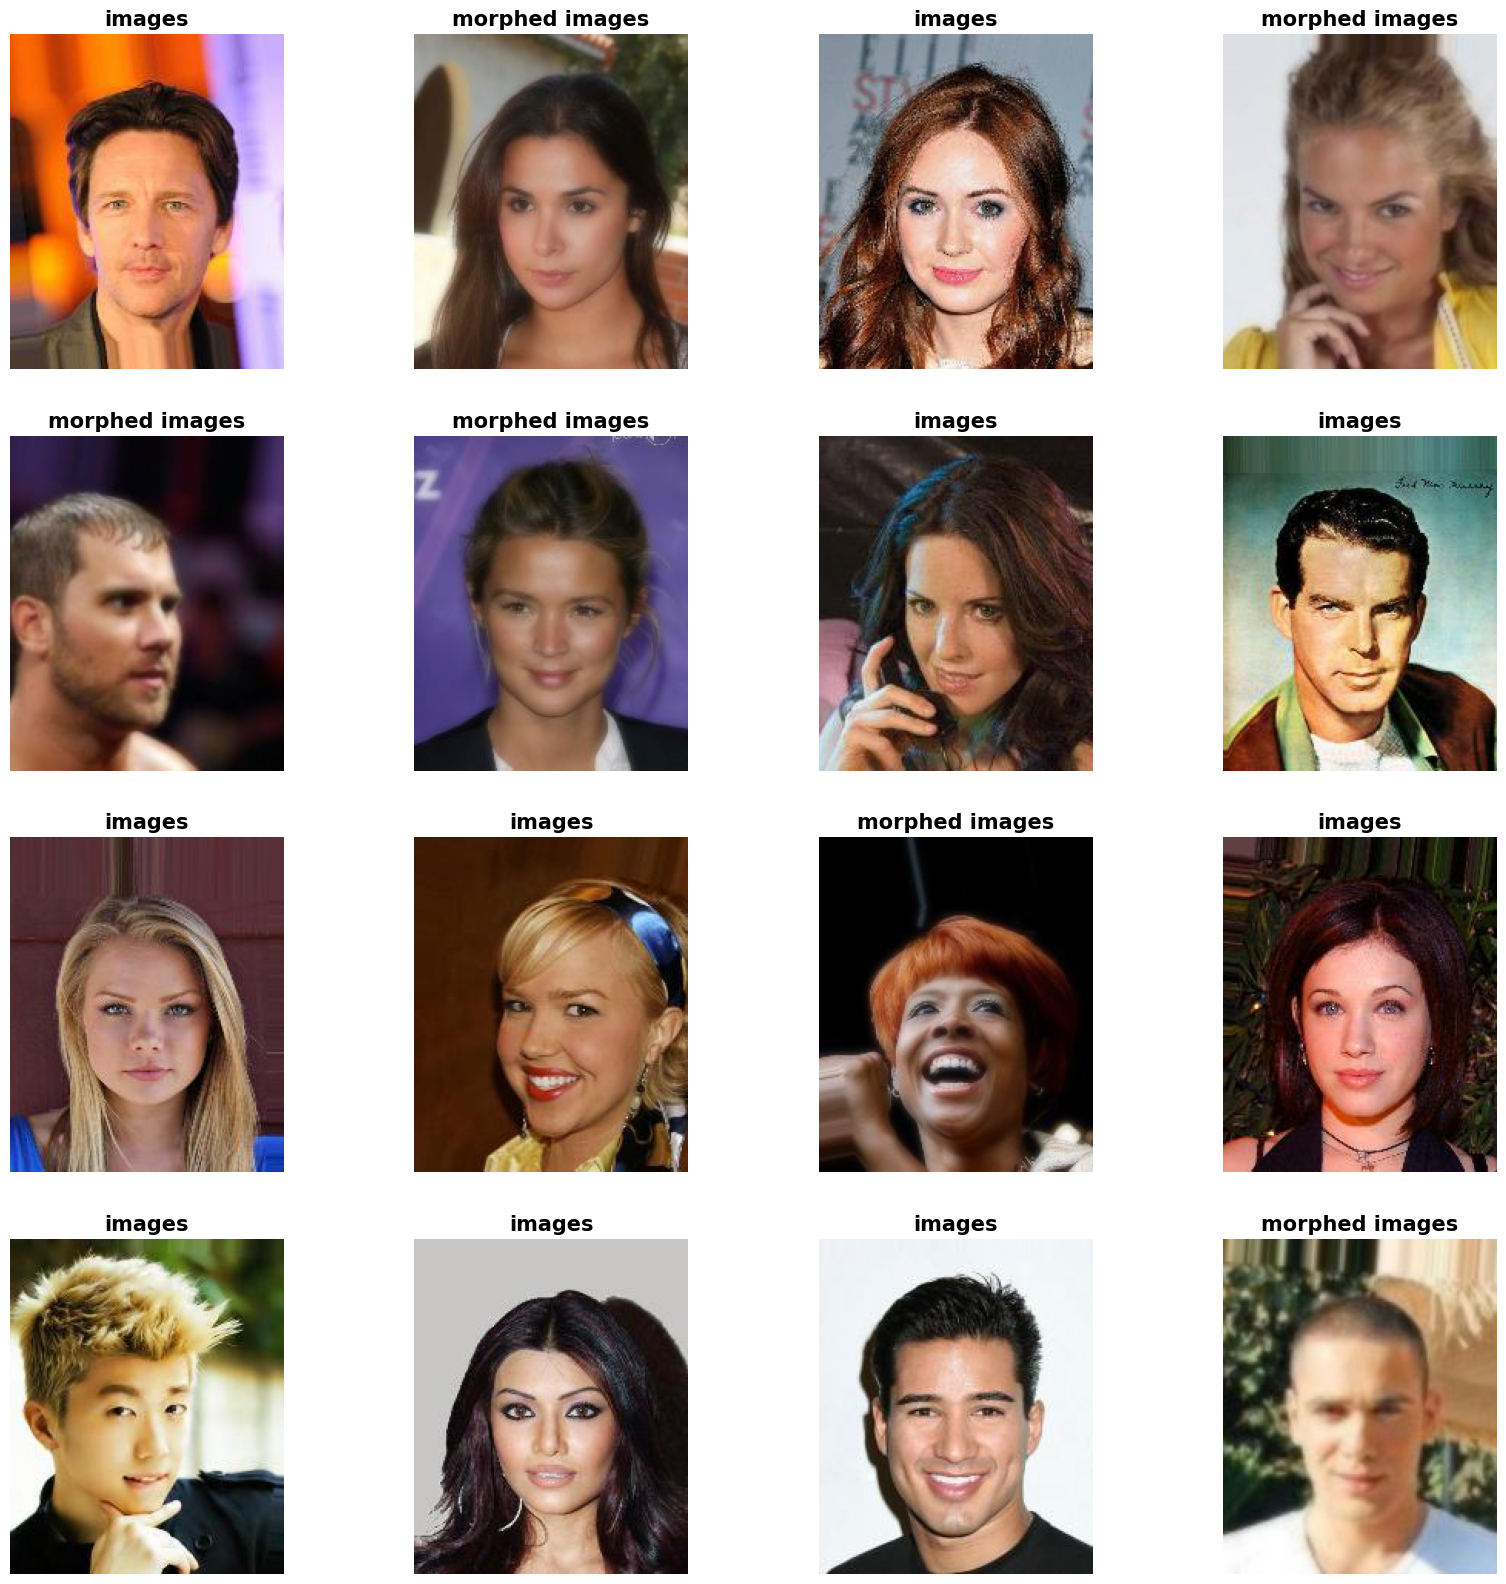

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))
for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    random_class = random.randint(0, 1)
    folder_path = file_path + '/' + class_names[random_class]
    random_image_path = folder_path + '/' + (random.sample(os.listdir(folder_path), 1)[0])
    image = plt.imread(random_image_path)
    plt.axis('off')
    plt.title(class_names[random_class], fontsize = 15, fontweight = 'bold')
    plt.imshow(image)

In [ ]:
os.makedirs('/content/drive/MyDrive/PROJECTS/morphed face detection/dataset/augmented-images')
os.makedirs('/content/drive/MyDrive/PROJECTS/morphed face detection/dataset/augmented-images/images')
os.makedirs('/content/drive/MyDrive/PROJECTS/morphed face detection/dataset/augmented-images/morphed images')

In [ ]:
image_dir="/content/drive/MyDrive/PROJECTS/morphed face detection/dataset"
def augment_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=0.1,
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  fill_mode='nearest'
                                 )

    for filename in listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        # reshape the image
        image = image.reshape((1,)+image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,save_prefix=save_prefix, save_format='jpg'):
                i += 1
                if i > n_generated_samples:
                    break

import os

augmented_data_path = '/content/drive/MyDrive/PROJECTS/morphed face detection/dataset/augmented-images'
if not os.path.exists(augmented_data_path):
    os.makedirs(augmented_data_path)
# augment data for the examples with label equal to 'yes' representing tumurous examples
augment_data(file_dir=image_dir+'/'+'images',n_generated_samples=6, save_to_dir=augmented_data_path+'/'+'images')
# augment data for the examples with label equal to 'no' representing non-tumurous examples
augment_data(file_dir=image_dir+'/'+'morphed images', n_generated_samples=9, save_to_dir=augmented_data_path+'/'+'morphed images')

In [ ]:
import pathlib
file_path = '/content/drive/MyDrive/PROJECTS/morphed face detection/dataset/augmented-images'
data_dir = pathlib.Path(file_path)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['images' 'morphed images']


In [ ]:
file_path = '/content/drive/MyDrive/PROJECTS/morphed face detection/dataset/augmented-images'
data_dir = pathlib.Path(file_path)

In [ ]:
import tensorflow as tf

SEED = 1
BATCH_SIZE = 64
IMG_SIZE = (128, 128)

# Split data into training and validation
train_val_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset='training'
)

# Split validation data into validation and testing
validation_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset='validation'
)

# Split validation data into validation and testing
val_test_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.5,  # Split half of the validation data for testing
    subset='validation'
)

# Assign the training, validation, and testing datasets
X_train = train_val_data
X_validation = validation_data
X_test = val_test_data


Found 8168 files belonging to 2 classes.
Using 6535 files for training.
Found 8168 files belonging to 2 classes.
Using 1633 files for validation.
Found 8168 files belonging to 2 classes.
Using 4084 files for validation.


In [ ]:
INPUT_SHAPE = IMG_SIZE + (3,)
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Rescaling(scale=1./255, input_shape=INPUT_SHAPE))
model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.20))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(2, activation = 'softmax'))

In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
# Set the hyperparameters
learning_rate = 0.0001
num_epochs = 15

In [ ]:
optimizer = Adam(learning_rate=learning_rate)

In [ ]:
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        1

In [ ]:
history = model.fit(X_train,epochs=num_epochs, validation_data=X_validation,verbose=1)

Epoch 1/15
103/103 [==============================] - 13s 124ms/step - loss: 0.1757 - accuracy: 0.9345 - val_loss: 0.2286 - val_accuracy: 0.9137
Epoch 2/15
103/103 [==============================] - 14s 126ms/step - loss: 0.1675 - accuracy: 0.9393 - val_loss: 0.2988 - val_accuracy: 0.8739
Epoch 3/15
103/103 [==============================] - 13s 123ms/step - loss: 0.1741 - accuracy: 0.9366 - val_loss: 0.1726 - val_accuracy: 0.9388
Epoch 4/15
103/103 [==============================] - 16s 147ms/step - loss: 0.1593 - accuracy: 0.9422 - val_loss: 0.1784 - val_accuracy: 0.9375
Epoch 5/15
103/103 [==============================] - 14s 126ms/step - loss: 0.1582 - accuracy: 0.9434 - val_loss: 0.1977 - val_accuracy: 0.9290
Epoch 6/15
103/103 [==============================] - 13s 124ms/step - loss: 0.1440 - accuracy: 0.9480 - val_loss: 0.1670 - val_accuracy: 0.9449
Epoch 7/15
103/103 [==============================] - 14s 125ms/step - loss: 0.1373 - accuracy: 0.9526 - val_loss: 0.2177 - val_ac

In [ ]:
model_evaluate = model.evaluate(X_test)
print("Accuracy: %", "{:.2f}".format(model_evaluate[1]*100))
print("Loss: %", "{:.2f}".format(model_evaluate[0]*100))

64/64 [==============================] - 7s 96ms/step - loss: 0.1133 - accuracy: 0.9608
Accuracy: % 96.08
Loss: % 11.33


[]

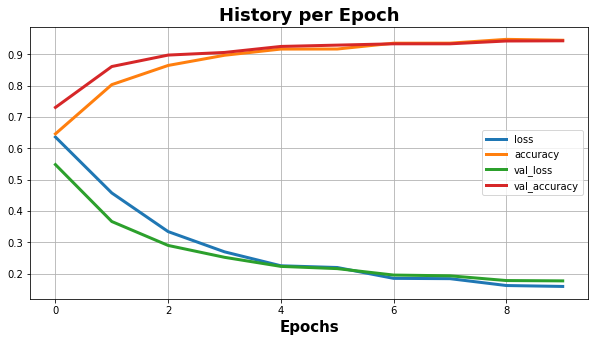

In [ ]:
df = pd.DataFrame(history.history)
ax = df.plot(figsize=(10,5), lw=3, grid='on')
ax.set_title('History per Epoch', fontsize=18, fontweight='bold')
ax.set_xlabel('Epochs', fontsize=15, fontweight='bold')
ax.plot()

In [ ]:
import pathlib
import numpy as np
file_path = '/content/drive/MyDrive/PROJECTS/morphed face detection/dataset/augmented-images/'
#class_names=['MildDemented','ModerateDemented','NonDemented','VeryMildDemented']
data_dir = pathlib.Path(file_path)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['images' 'morphed images']


1/1 [==============================] - 0s 25ms/step


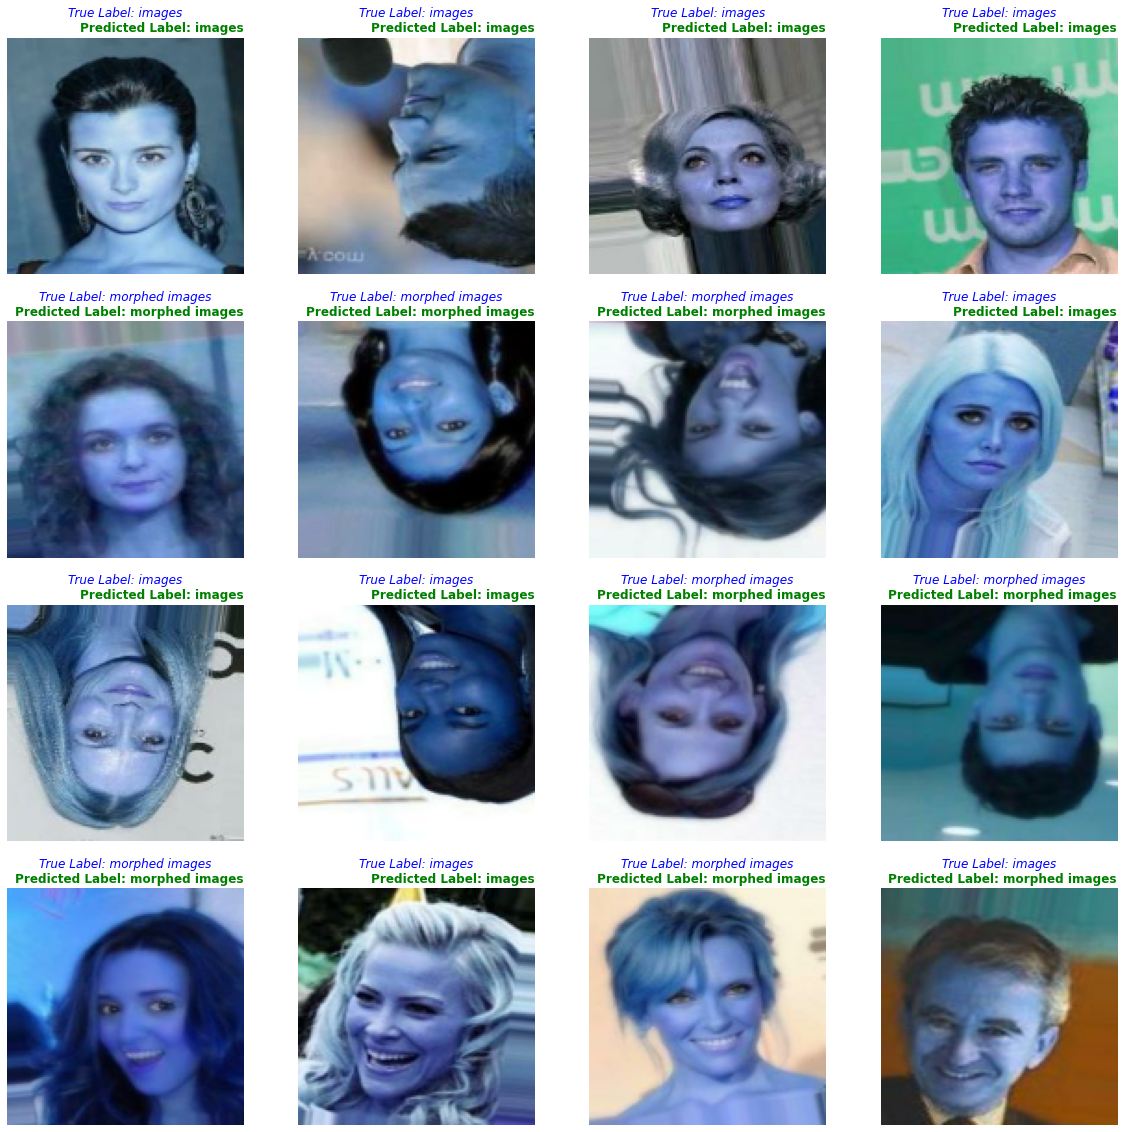

In [ ]:
plt.figure(figsize=(20, 20))
for image, label in X_validation.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i+1)
        img = image[i].numpy().astype("uint8")
        img = tf.expand_dims(img, axis=0)
        predicted_class = np.argmax(model.predict(img))
        plt.axis('off')
        plt.title("True Label: " + class_names[label[i]]+'\n', fontsize=12, style='italic', color='blue', loc='center')
        plt.title("Predicted Label: " + class_names[predicted_class], fontsize=12, fontweight='bold', color='green', loc='right')
        plt.imshow(image[i].numpy().astype("uint8"))

In [ ]:
model.save('model2023.h5')

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('model2023.h5')


In [ ]:
!pip install gradio

In [ ]:
import gradio as gr
import cv2


# Define a function to run the model on user input and return predictions
def predict_image(img_array):
    img_array = cv2.resize(img_array, (128,128))
    img_array = np.array(img_array).reshape(1,128,128, 3)
    prediction = model.predict([img_array])
    class_idx = np.argmax(prediction)
    class_name = class_names[class_idx]
    return class_name

# Define the input and output components of the Gradio interface
inputs = gr.inputs.Image(shape=(128, 128))
outputs = gr.outputs.Label(num_top_classes=len(class_names))

# Create the Gradio interface
interface = gr.Interface(fn=predict_image, inputs=inputs, outputs=outputs,
                         title='Morphed Face Detection')

# Launch the interface
interface.launch(share=True,debug=True)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://cd2c70c5b9be6ab4af.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


1/1 [==============================] - 0s 22ms/step
